
# Project: Investigate a Soccer Data Set

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href='#limit_players'> Players analysis limitations and conclusion</a></li>
<li><a href='#limit_teams'>Teams analysis limitations and conclusion</a></li>
</ul>

<a id='intro'></a>
## Introduction

> The data I chose is Soccer database. At the first glance it was looking promissing but once I got deeper I found that data itself was not from "real" world... As example Arsenal's team average attributes is almost equal to not so well known football club - Real Sporting de Gijon. I read through introductory part and found that data mostly taken from FIFA game series and match results got scrapped from online aggregators. Nevertheless there have been all required connections between tables and we could work with it in more details.
So the questions i came up with:    
> Does the amount of goals made by players greatly depends on shot power? Do the players with higher shot power attr score more goals.    
> Do the left footed players score more often on average than right footed ?    
The second set of questions related to team's performance.    
> Get the lsit of top teams based on attributes and games played + most improved teams on a given timeframe (season).

In [1]:
import pandas as pd
import sqlite3 as sql
from sqlite3 import Error
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from soccer.global_var.query import SQLpatterns, REGEXpatterns

<a id='wrangling'></a>
## Data Wrangling

> As data represented in sqllite file we are going to need sql connector. Lets create one.

In [2]:
def connect(data_base):
    try:
        conn = sql.connect(data_base)
        return conn
    except Error as e:
        print(e)
    return None

cn = connect("./soccer/data/database.sqlite")

In [3]:
player_attr = pd.read_sql_query(SQLpatterns.get_all_players_attr, cn)

In [4]:
player_attr.shape

(183978, 42)

In [5]:
player_attr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183978 entries, 0 to 183977
Data columns (total 42 columns):
id                     183978 non-null int64
player_fifa_api_id     183978 non-null int64
player_api_id          183978 non-null int64
date                   183978 non-null object
overall_rating         183142 non-null float64
potential              183142 non-null float64
preferred_foot         183142 non-null object
attacking_work_rate    180748 non-null object
defensive_work_rate    183142 non-null object
crossing               183142 non-null float64
finishing              183142 non-null float64
heading_accuracy       183142 non-null float64
short_passing          183142 non-null float64
volleys                181265 non-null float64
dribbling              183142 non-null float64
curve                  181265 non-null float64
free_kick_accuracy     183142 non-null float64
long_passing           183142 non-null float64
ball_control           183142 non-null float64
accele

### General Properties

So now we can take a look at our data. What we are seeing is that there is lots of missing data. 
We will be selecting the following columns: both player ids, overall rating,preferred foot and shot power. Since there 
has been data related to several years we gonna select average on numeric columns from above columns over all available years. To get players name we have to join Player_Attributes table with Player one on id column. To get averages we can group data on id field and use built-in sql functions. Also we will try to avoid all null values within our sql query.

> Here is the sql query to join data from two tables avoiding NULL and group it on id:    

```select p.player_name, pa_id.player_fifa_api_id, pa_id.player_api_id, pa_id.preferred_foot, pa_id.avr_sp, pa_id.avr_r
   from
    (select player_fifa_api_id, player_api_id, preferred_foot, avg(shot_power) as avr_sp, avg(overall_rating) as avr_r
     from Player_Attributes
         where overall_rating is not null and preferred_foot is not null and shot_power is not null
         group by player_fifa_api_id)  pa_id
   inner join Player p
   on p.player_fifa_api_id = pa_id.player_fifa_api_id
   Order by avr_r DESC, avr_sp DESC```

In [6]:
players_ratings = pd.read_sql_query(SQLpatterns.select_players_attr, cn)


In [7]:
players_ratings.head(5)

,player_name,player_fifa_api_id,player_api_id,preferred_foot,avr_sp,avr_r
0,Lionel Messi,158023,30981,left,80.307692,92.192308
1,Cristiano Ronaldo,20801,30893,right,92.760000,91.280000
2,Franck Ribery,156616,30924,right,75.333333,88.458333
3,Andres Iniesta,41,30955,right,66.840000,88.320000
4,Zlatan Ibrahimovic,41236,35724,right,91.761905,88.285714


> Here we`ve got compact table comprised of name, ids, foot and averages on shot power and rating. Next we need to pull data from matches table.    ```select * from Match```

In [8]:
match_df = pd.read_sql_query(SQLpatterns.get_all_games, cn)

In [9]:
match_df.head(5)

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,...,4.00,1.65,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.20
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,...,3.80,2.00,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.60
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,...,2.50,2.35,3.25,2.65,2.50,3.20,2.50,2.30,3.20,2.75
3,4,1,1,2008/2009,1,2008-08-17 00:00:00,492476,9991,9998,5,...,7.50,1.45,3.75,6.50,1.50,3.75,5.50,1.44,3.75,6.50
4,5,1,1,2008/2009,1,2008-08-16 00:00:00,492477,7947,9985,1,...,1.73,4.50,3.40,1.65,4.50,3.50,1.65,4.75,3.30,1.67


Now we need to extract goals and associate it with players. Lets have a brief look into goal column.

In [10]:
match_df.goal.head(5)

0    None
1    None
2    None
3    None
4    None
Name: goal, dtype: object

Lots of rows are None, so we need to see how many real rows we could rely on. It turns out that almost one half is absent but we still can use it. Quick dive into row values gives us something is looking like xml format where data  divided by tags. I looked through several examples and all of them are based on same rules so we can state the following:
player1 - the one who scored the goal
player2 - assisted
If player2 tag is not in body of goal that means player1 did goal on his own without any assistance.

In [11]:
match_df.goal.unique().__len__()

13226

In [12]:
match_df.goal.unique()[1]

'<goal><value><comment>n</comment><stats><goals>1</goals><shoton>1</shoton></stats><event_incident_typefk>406</event_incident_typefk><elapsed>22</elapsed><player2>38807</player2><subtype>header</subtype><player1>37799</player1><sortorder>5</sortorder><team>10261</team><id>378998</id><n>295</n><type>goal</type><goal_type>n</goal_type></value><value><comment>n</comment><stats><goals>1</goals><shoton>1</shoton></stats><event_incident_typefk>393</event_incident_typefk><elapsed>24</elapsed><player2>24154</player2><subtype>shot</subtype><player1>24148</player1><sortorder>4</sortorder><team>10260</team><id>379019</id><n>298</n><type>goal</type><goal_type>n</goal_type></value></goal>'

>To parse this data we need to get all not null cells and apply regexp against each row that returns player id value from each xml. There could be more than one goal event per cell so we need to extract all of them. But before we apply that search we need prepare list of players ids we want to know about. As right footed players seen many times more than left footed ones and both these group could have had representatives in different skills groups we will try to pre-select both left and right footed players in each group. For that we will use overall rating column from Player table.


### Data Cleaning

Using players_ratings object trying to find all players fall into 3 skilled groups: low(**0-50%**), med(**50-75%**), high(**75 and above**).

In [13]:
players_ratings.describe()

,player_fifa_api_id,player_api_id,avr_sp,avr_r
count,11060.000000,11060.000000,11060.000000,11060.000000
mean,165664.910488,156510.905606,59.478922,66.820293
std,58649.928360,160704.976236,15.251594,6.238134
min,2.000000,2625.000000,9.923077,43.000000
25%,151889.500000,35542.750000,52.000000,62.818182
50%,184671.000000,96617.500000,62.875000,66.714286
75%,203883.250000,212422.250000,70.385684,70.956522
max,234141.000000,750584.000000,93.076923,92.192308


In [14]:
# Unpack values to filter data between set borders. 
#Applying this function to each distribution we are getting all existing players ids split into several categories.
f = lambda x: players_ratings.query('preferred_foot == "{}" and avr_sp > {} and avr_sp < {}'.format(*x))

In [15]:
def get_players(player_ratings_df, match_df):
    """
    :param player_ratings_df: player ratings
    :param match_df: available Match data
    
    Filters player rating based on parameters coming in lambda function. Unpacking and substituting corresponding place
    holders in search query. 
    Creates two distribution lists for left and right footed players. Lists in their turn aggregate data on 3 levels:
    low, medium and high. 
    To select Match data for these 3 level tiers distribution get_goals_scored subroutines is used. It finds and adds 
    amount of goals scored by each player in each distribution group.
    
    """
    f = lambda x: player_ratings_df.query('preferred_foot == "{}" and avr_sp > {} and avr_sp < {}'.format(*x))
    distribution_left = {}
    distribution_right = {}
    stats = player_ratings_df['avr_sp'].describe()
    match_filtered = match_df[match_df['goal'].notnull()]
    extract_id_data = match_filtered['goal'].str.extractall(REGEXpatterns.player_ids)['id'].value_counts()

    distribution_left["50%"] = f(('left', stats['25%'], stats['50%']))
    distribution_left["75%"] = f(('left', stats['50%'], stats['75%']))
    distribution_left["max"] = f(('left', stats['75%'], 100))

    distribution_right["50%"] = f(('right', stats['25%'], stats['50%']))
    distribution_right["75%"] = f(('right', stats['50%'], stats['75%']))
    distribution_right["max"] = f(('right', stats['75%'], 100))

    get_goals_scored(extract_id_data, distribution_left)
    get_goals_scored(extract_id_data, distribution_right)
    showcase_dist(distribution_left, distribution_right)
    leveloff_distribution(distribution_left, distribution_right)

Here we have found all id's and filter them into 3 groups. Now we need to match filtered ids with the ones extracted from 'goal' column of Match table. We are iterating through distribution keys and looking for each key within extracted data. If it is not existed in 'goal' column we get rid of it from distribution.
Given results are converted to numpay array and attached as 'goals_scored' column to our distribution.

In [16]:
def get_goals_scored(id_data, distribution):
    """

    :param id_data: extracted players id's and goals
    :param distribution: left, right distributions groups
    Lookup values from distribution within extracted data.

    """
    goals = []
    for k in distribution.keys():
        data = distribution[k]
        val_data = data['player_api_id'].get_values()
        for x in val_data:
            try:
                goal = id_data[str(x)]
                goals.append(goal)
            except KeyError:
                # remove key as not existed or never scored
                distribution[k] = distribution[k][distribution[k].player_api_id != x]
        res = np.array(goals)
        # attach to initial distribution
        distribution[k] = distribution[k].assign(goals_scored=res)
        del goals[:] # clean buffer

Idea below is to get two groups(left and right) each of which has 3 tuples for each category: 
Left->'50%'(scored, shot power),'50-75%'(scored, shot power), 75-100%(scored, shot power).
Righ->'50%'(scored, shot power),'50-75%'(scored, shot power), 75-100%(scored, shot power).
Then we are unpaking tuples to have left and right values of power and goal for each group
**Ex: goals (3.4293193717277486, 6.1038461538461535, 12.675000000000001), power(58.552288155823717, 66.73506094955215, 76.53957234305993)**

In [17]:
def showcase_dist(distribution_left, distribution_right):
    left_goals, left_power = zip(
        *[(distribution_left[d]['goals_scored'].mean(), distribution_left[d]['avr_sp'].mean()) for d in
          distribution_left])
    right_goals, right_power = zip(
        *[(distribution_right[d]['goals_scored'].mean(), distribution_right[d]['avr_sp'].mean()) for d in
          distribution_right])

    sns.set_style("darkgrid")
    sns.axes_style()
    plt.figure(figsize=(20, 10))
    plt.yticks([0, 3.5, 6, 12, 16])
    plt.ylabel('Goals scored (mean)')
    plt.xlabel('Power of shot (mean)')
    plt.title('Proportion by Shot Power and Goals')

    bp = sns.barplot(x=right_power, y=right_goals, color="salmon", label="Right footed players")
    sns.barplot(x=left_power, y=left_goals, color="purple", label="Left footed players")
    bp.set_xticklabels(('Low power (0-50%)', 'Average (50-75%)', 'Strong (above 75%)'))
    plt.legend()
    plt.show()

Setting up figure for bar charts and applying our data. We created 3 columns (0-50, 50-75, 75-100) of power distribution (x Axis) and amount of gols made (y Axis) for left and right footed players.

In [18]:
#Second plot will be showing adjusted distribution so samples from both side are equal in amount in each group
def leveloff_distribution(dist1, dist2):
    for k in dist1.keys():
        d1_l = len(dist1[k])
        d2_l = len(dist2[k])
        m = min(d1_l, d2_l)
        if m == d1_l:
            dist2[k] = dist2[k].sample(d1_l)
        else:
            dist1[k] = dist1.sample(d2_l)
    showcase_dist(dist1, dist2)

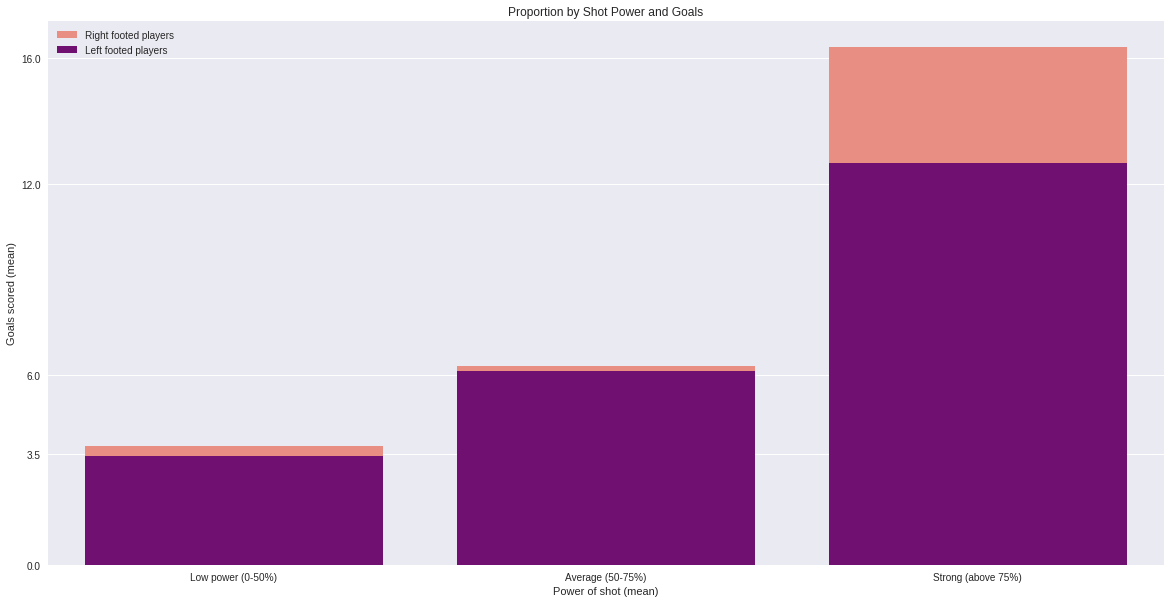

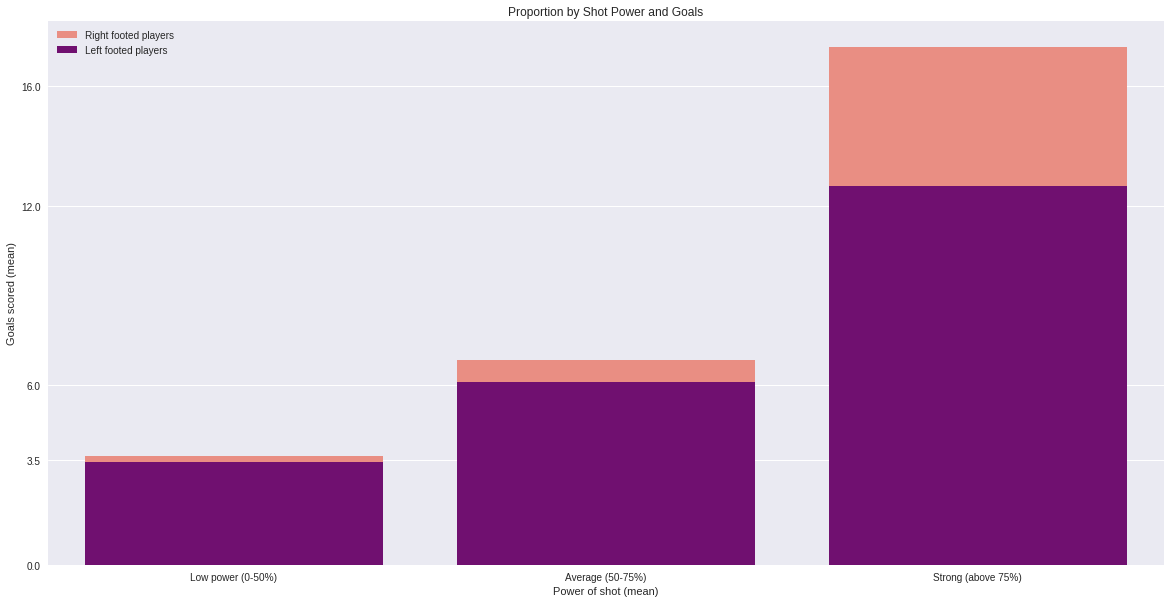

In [19]:
%matplotlib inline
get_players(players_ratings, match_df)

Here i am going to change a bit approach and transform data in a different way. The idea remains the same but code will be slightly changed.

In [36]:
def get_goals_scored_impr(id_data, distribution):
    """
    :param id_data: extracted players id's and goals
    :param distribution: left, right distributions groups
    Lookup values from distribution within extracted data.

    """
    goals = []
    val_data = distribution['player_api_id'].get_values()
    for x in val_data:
        try:
            goal = id_data[str(x)]
            goals.append(goal)
        except KeyError:
            # remove key as not existed or never scored
            distribution = distribution[distribution.player_api_id != x]
    res = np.array(goals)
    # attach to initial distribution
    return distribution.assign(goals_scored=res)

def get_players_impr(player_ratings_df, match_df):
    """
    :param player_ratings_df: player ratings
    :param match_df: available Match data

    Filters player rating based on parameters coming in lambda function. Unpacking and substituting corresponding place
    holders in search query.
    Creates two distribution lists for left and right footed players. Lists in their turn aggregate data on 3 levels:
    low, medium and high.
    For each distribution group applies 'goal' column search against regExp that includes player id.
    Appends data to existed distribution.
    To select Match data for these 3 level tiers distribution get_goals_scored subroutines is used. It finds and adds
    amount of goals scored by each player in each distribution group.

    """
    f = lambda x: player_ratings_df.query('preferred_foot == "{}" and avr_sp > {} and avr_sp < {}'.format(*x))
    stats = player_ratings_df['avr_sp'].describe()
    match_filtered = match_df[match_df['goal'].notnull()]
    extract_id_data = match_filtered['goal'].str.extractall(REGEXpatterns.player_ids)['id'].value_counts()
    p = f(('left', stats['25%'], stats['50%']))
    p1 = f(('left', stats['50%'], stats['75%']))
    p2 = f(('left', stats['75%'], 100))

    a, a1, a2 = np.empty(len(p), dtype='U3'),\
                np.empty(len(p1), dtype='U3'),\
                np.empty(len(p2), dtype='U3')

    a.fill('50%')
    a1.fill('75%')
    a2.fill('max')
    d = p.assign(distr=a)
    d1 =p1.assign(distr=a1)
    d2 =p2.assign(distr=a2)
    x = pd.concat([d,d1,d2])

    p = f(('right', stats['25%'], stats['50%']))
    p1 = f(('right', stats['50%'], stats['75%']))
    p2 = f(('right', stats['75%'], 100))

    a, a1, a2 = np.empty(len(p), dtype='U3'),\
                np.empty(len(p1), dtype='U3'),\
                np.empty(len(p2), dtype='U3')

    a.fill('50%')
    a1.fill('75%')
    a2.fill('max')
    d = p.assign(distr=a)
    d1 = p1.assign(distr=a1)
    d2 = p2.assign(distr=a2)
    x1 = pd.concat([d,d1,d2])
    res = pd.concat([x, x1])
    res = get_goals_scored_impr(extract_id_data, res)

    sns.lmplot(x="avr_sp", y="goals_scored", hue="preferred_foot",
               truncate=True, size=10, aspect=1.7, data=res)
    plt.title('Left/Right goal distribution')
    sns.lmplot(x="avr_sp", y="goals_scored", hue="distr",
               truncate=True, size=10, aspect=1.7, data=res)
    plt.title('Groups goal distribution')

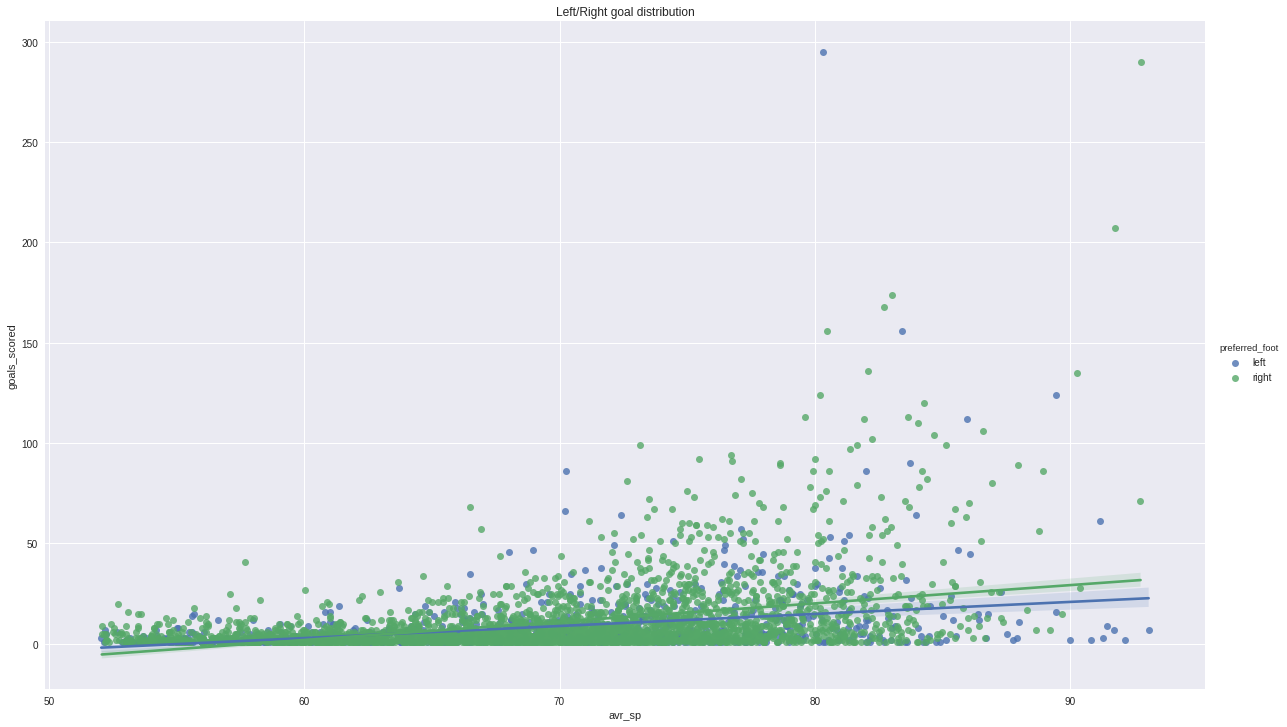

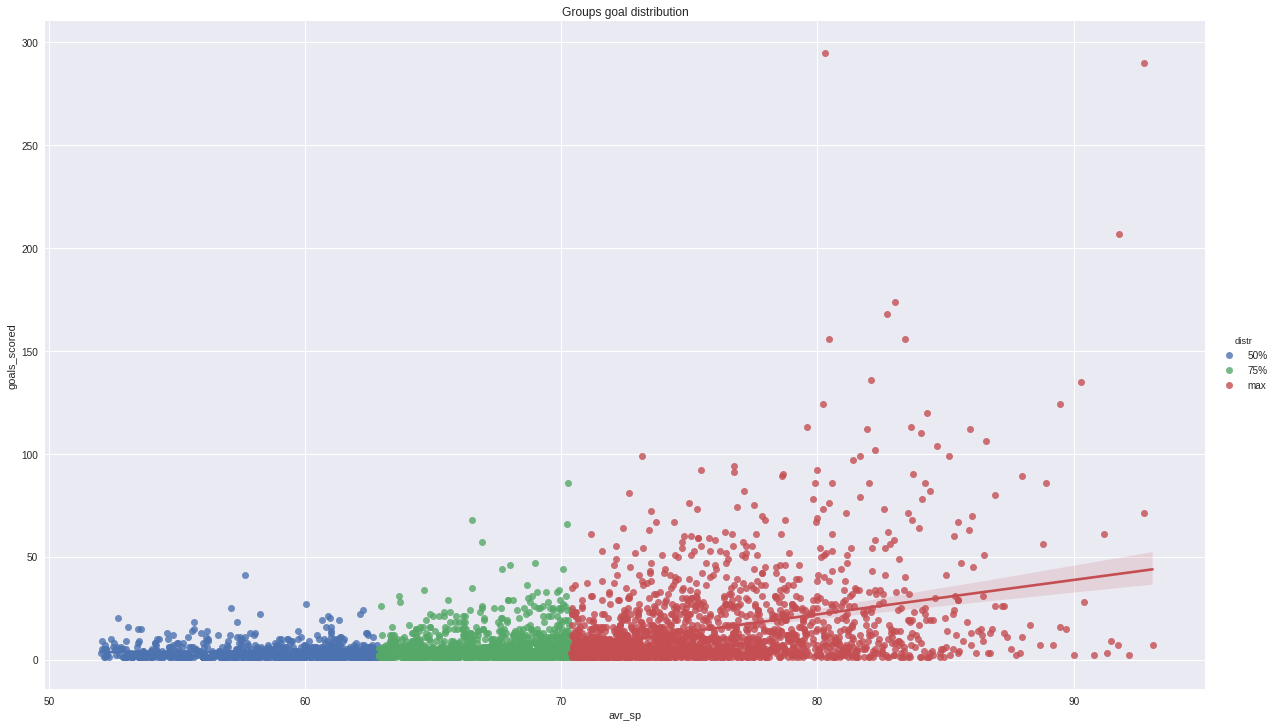

In [37]:
get_players_impr(players_ratings, match_df)

<a id='limit_players'></a>
### Limitations
- Amount of players with left foot preferred. Given data has 8538 players with right foot and 2522 "left" ones.
After joining tables left footed players amount becomes **2015** (655,659,702) and right footed **6235** (2108, 2064, 2063) so there is 3 times difference in amount.
- Lots of missing data in "goal" column. There is only data existed for 4355 player's id. After joining tables results are as follows: left id **891**(191 260 440), right **2902**(626 893 1383). I am not sure if we are claculating mean values would that difference in amount make any impact.
- Goals data is **not normalized**, it could be represented as separate instance (table) with connections. Now it is stored as xml so it hard to process and takes time, escecially when you do run RegExp against it.
- Not sure if reducing right foot distribution amount down to amounf of left and than compare against each other worth implementing. Have tried several random distributions within equal amount of players's id both for left and right footed and did not notice that results drammatically changed.
- Preferred foot doesnt exactly mean that players use only that one, they could score with both so it could definetelly greatly affect the numbers we prepared.

<a id='eda'></a>
### Conclusion
#### Does the amount of goals made by players greatly depends on shot power? Do the players with higher shot power attr score more goals. Do the left footed players score more often on average than right footed ?

From the chart above we see that the **players with greater shooting power values have scored more goals**. There are 3 groups created to see distribution within each of low, medium, high borders of skill. Each iteration left footed players  increase rating almost twice as much as previous group had.    Speaking of right footed players the great leap made on the higher levels of skill possesion. It is definetelly increases.    
With regards to left-right ratio based on our distribution **right footed score more often and especially on high levels of shooting power**.


###  Get the lsit of top teams based on attributes and games played + most improved teams on a given timeframe (season).

> To select team attributes, name and won/lose rate we will need complex sql query. Lets look into data before start creating it.


In [22]:
team_attr_df = pd.read_sql_query("Select * from Team_Attributes", cn)

In [23]:
team_attr_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458 entries, 0 to 1457
Data columns (total 25 columns):
id                                1458 non-null int64
team_fifa_api_id                  1458 non-null int64
team_api_id                       1458 non-null int64
date                              1458 non-null object
buildUpPlaySpeed                  1458 non-null int64
buildUpPlaySpeedClass             1458 non-null object
buildUpPlayDribbling              489 non-null float64
buildUpPlayDribblingClass         1458 non-null object
buildUpPlayPassing                1458 non-null int64
buildUpPlayPassingClass           1458 non-null object
buildUpPlayPositioningClass       1458 non-null object
chanceCreationPassing             1458 non-null int64
chanceCreationPassingClass        1458 non-null object
chanceCreationCrossing            1458 non-null int64
chanceCreationCrossingClass       1458 non-null object
chanceCreationShooting            1458 non-null int64
chanceCreationShootin

> Almost 2/3 of buildUpPlayDribbling column is not in place so we skipping this column as it is not relevant to most of the teams.    
Lets look at date column. It seems to be date and time format but time part is always the same. Going further we will skip that part of date as redundant.

In [24]:
team_attr_df.date[0:3]

0    2010-02-22 00:00:00
1    2014-09-19 00:00:00
2    2015-09-10 00:00:00
Name: date, dtype: object

In [25]:
team_attr_df.head(5)

,id,team_fifa_api_id,team_api_id,date,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribbling,buildUpPlayDribblingClass,buildUpPlayPassing,buildUpPlayPassingClass,...,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass
0,1,434,9930,2010-02-22 00:00:00,60,Balanced,NaN,Little,50,Mixed,...,55,Normal,Organised,50,Medium,55,Press,45,Normal,Cover
1,2,434,9930,2014-09-19 00:00:00,52,Balanced,48.0,Normal,56,Mixed,...,64,Normal,Organised,47,Medium,44,Press,54,Normal,Cover
2,3,434,9930,2015-09-10 00:00:00,47,Balanced,41.0,Normal,54,Mixed,...,64,Normal,Organised,47,Medium,44,Press,54,Normal,Cover
3,4,77,8485,2010-02-22 00:00:00,70,Fast,NaN,Little,70,Long,...,70,Lots,Organised,60,Medium,70,Double,70,Wide,Cover
4,5,77,8485,2011-02-22 00:00:00,47,Balanced,NaN,Little,52,Mixed,...,52,Normal,Organised,47,Medium,47,Press,52,Normal,Cover


> We could build up average rating on numerical values over the years since each team id existed more than once. Averages on time frame sounds as good idea given the fact not all teams have equal distribution over the years. Some of them have 2 years of observations and some five or even six. so we will aggregate them. 

> Also to build team's performance report we gonna need results of games played (won/lose/draw) within each season to see how team has improved since last season. And to find most improved team data shoud be relative to each time frame.
Lets take a look into Match data once again. The two columns we need there are home_team_goal and away_team_goal. It represented not in super handy format as we need to calculate how many they scored as home team + away team and how many they missed as home team and away team.

In [26]:
match_df.head(5)

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,...,4.00,1.65,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.20
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,...,3.80,2.00,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.60
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,...,2.50,2.35,3.25,2.65,2.50,3.20,2.50,2.30,3.20,2.75
3,4,1,1,2008/2009,1,2008-08-17 00:00:00,492476,9991,9998,5,...,7.50,1.45,3.75,6.50,1.50,3.75,5.50,1.44,3.75,6.50
4,5,1,1,2008/2009,1,2008-08-16 00:00:00,492477,7947,9985,1,...,1.73,4.50,3.40,1.65,4.50,3.50,1.65,4.75,3.30,1.67


To achive that we are using two "select" queries and unioun clause. We select same data from same table but in a bit different manner. First block selects as it was away team and second one is it was home team. So home and away goals counts differently. To get full picture of home-away values we join both table and group them by id to see how much win/loose, score, etc have been made in ach season.    
```select away_team_api_id as id, 
				sum(away_team_goal) as scored, 
				sum(home_team_goal) as lost, 
			    count(case when away_team_goal > home_team_goal then 1 end) as won,
				count(case when away_team_goal = home_team_goal then 1 end ) as draw,
				count(case when away_team_goal < home_team_goal then 1 end) as lose,
				date as y
		from Match
		group by y,  id
	union
		select home_team_api_id as id, 
				sum(home_team_goal) as scored, 
				sum(away_team_goal) as lost, 
				count(case when home_team_goal > away_team_goal then 1 end) as won,
				count(case when home_team_goal = away_team_goal then 1 end ) as draw,
				count(case when home_team_goal < away_team_goal then 1 end) as lose,
				date as y
		from Match
		group by y, id```
Using count - case construction to count amount win/lose.

In [27]:
q = """
select away_team_api_id as id, 
				sum(away_team_goal) as scored, 
				sum(home_team_goal) as lost, 
			    count(case when away_team_goal > home_team_goal then 1 end) as won,
				count(case when away_team_goal = home_team_goal then 1 end ) as draw,
				count(case when away_team_goal < home_team_goal then 1 end) as lose,
				date as y
		from Match
		group by y,  id
	union
		select home_team_api_id as id, 
				sum(home_team_goal) as scored, 
				sum(away_team_goal) as lost, 
				count(case when home_team_goal > away_team_goal then 1 end) as won,
				count(case when home_team_goal = away_team_goal then 1 end ) as draw,
				count(case when home_team_goal < away_team_goal then 1 end) as lose,
				date as y
		from Match
		group by y, id
"""
res = pd.read_sql_query(q, cn)
res[0:10]

,id,scored,lost,won,draw,lose,y
0,1601,0,0,0,1,0,2008-08-10 00:00:00
1,1601,0,0,0,1,0,2008-09-27 00:00:00
2,1601,0,0,0,1,0,2008-10-24 00:00:00
3,1601,0,0,0,1,0,2008-11-08 00:00:00
4,1601,0,0,0,1,0,2009-04-04 00:00:00
5,1601,0,0,0,1,0,2009-05-10 00:00:00
6,1601,0,0,0,1,0,2009-09-27 00:00:00
7,1601,0,0,0,1,0,2009-11-28 00:00:00
8,1601,0,0,0,1,0,2010-04-03 00:00:00
9,1601,0,0,0,1,0,2010-08-08 00:00:00


> We still have problem here with date format. We gonna take care of it a bit later. For now lets rebuild a bit temp table for the sake of usability to perform next join on it.

In [28]:
q="""select match_stat.id as id, 
				sum(match_stat.scored) as scored, 
				sum(match_stat.won) as won, 
				sum(match_stat.draw) as draw, 
				sum(match_stat.lose) as lose, 
				sum(match_stat.lost) as got, 
				match_stat.y as years
from
		(select away_team_api_id as id, 
				sum(away_team_goal) as scored, 
				sum(home_team_goal) as lost, 
			    count(case when away_team_goal > home_team_goal then 1 end) as won,
				count(case when away_team_goal = home_team_goal then 1 end ) as draw,
				count(case when away_team_goal < home_team_goal then 1 end) as lose,
				date as y
		from Match
		group by y,  id
	union
		select home_team_api_id as id, 
				sum(home_team_goal) as scored, 
				sum(away_team_goal) as lost, 
				count(case when home_team_goal > away_team_goal then 1 end) as won,
				count(case when home_team_goal = away_team_goal then 1 end ) as draw,
				count(case when home_team_goal < away_team_goal then 1 end) as lose,
				date as y
		from Match
		group by y, id) match_stat
     group by years, id
    order by id"""
res = pd.read_sql_query(q, cn)
res[0:10]

,id,scored,won,draw,lose,got,years
0,1601,0,0,1,0,0,2008-08-10 00:00:00
1,1601,2,1,0,0,1,2008-08-16 00:00:00
2,1601,2,1,0,0,1,2008-08-22 00:00:00
3,1601,0,0,0,1,3,2008-08-30 00:00:00
4,1601,2,1,0,0,0,2008-09-12 00:00:00
5,1601,0,0,0,1,3,2008-09-20 00:00:00
6,1601,0,0,1,0,0,2008-09-27 00:00:00
7,1601,0,0,0,1,1,2008-10-04 00:00:00
8,1601,2,1,0,0,0,2008-10-19 00:00:00
9,1601,0,0,1,0,0,2008-10-24 00:00:00


Now we can select all the needed info from both table (Team_Attributes)    

```select ta.team_api_id as id, 
		substr(date,0,5) as season,
		(buildUpPlaySpeed+buildUpPlayPassing+
		chanceCreationPassing+chanceCreationCrossing+chanceCreationShooting+
		defencePressure+defenceAggression+defenceTeamWidth)/8 as average,		
		sum(year_stats.scored) as scored, 
		sum(year_stats.got) as got,
		sum(year_stats.won) as won, 
		sum(year_stats.draw) as draw, 
		sum(year_stats.lose) as lose, 
		t.team_long_name,
		t.team_short_name
from Team_Attributes ta```

and join this with temp page we created 

    


```select ta.team_api_id as id, 
		substr(date,0,5) as season,
		(buildUpPlaySpeed+buildUpPlayPassing+
		chanceCreationPassing+chanceCreationCrossing+chanceCreationShooting+
		defencePressure+defenceAggression+defenceTeamWidth)/8 as average,		
		sum(year_stats.scored) as scored, 
		sum(year_stats.got) as got,
		sum(year_stats.won) as won, 
		sum(year_stats.draw) as draw, 
		sum(year_stats.lose) as lose, 
		t.team_long_name,
		t.team_short_name```
```from Team_Attributes ta 
INNER JOIN Team t
ON ta.team_api_id = t.team_api_id
INNER JOIN
		(select match_stat.id as id, 
				sum(match_stat.scored) as scored, 
				sum(match_stat.won) as won, 
				sum(match_stat.draw) as draw, 
				sum(match_stat.lose) as lose, 
				sum(match_stat.lost) as got, 
				match_stat.y as years
from
		(select away_team_api_id as id, 
				sum(away_team_goal) as scored, 
				sum(home_team_goal) as lost, 
			    count(case when away_team_goal > home_team_goal then 1 end) as won,
				count(case when away_team_goal = home_team_goal then 1 end ) as draw,
				count(case when away_team_goal < home_team_goal then 1 end) as lose,
				date as y
		from Match
		group by y,  id
	union
		select home_team_api_id as id, 
				sum(home_team_goal) as scored, 
				sum(away_team_goal) as lost, 
				count(case when home_team_goal > away_team_goal then 1 end) as won,
				count(case when home_team_goal = away_team_goal then 1 end ) as draw,
				count(case when home_team_goal < away_team_goal then 1 end) as lose,
				date as y
		from Match
		group by y, id) match_stat
    group by years, id
    order by id) year_stats
ON year_stats.id = ta.team_api_id 
AND substr(year_stats.years, 0, 5) = substr(season, 0, 5)
GROUP BY ta.team_api_id, season
ORDER BY id```

We did some aggregation by hand and some using standard functions. Also we cut 5 first signs from date column to have season's year. Joining data on id and year to prepare data separated by years for easy analysis.

In [29]:
q="""select ta.team_api_id as id, 
		substr(date,0,5) as season,
		(buildUpPlaySpeed+buildUpPlayPassing+
		chanceCreationPassing+chanceCreationCrossing+chanceCreationShooting+
		defencePressure+defenceAggression+defenceTeamWidth)/8 as average,		
		sum(year_stats.scored) as scored, 
		sum(year_stats.got) as got,
		sum(year_stats.won) as won, 
		sum(year_stats.draw) as draw, 
		sum(year_stats.lose) as lose, 
		t.team_long_name,
		t.team_short_name
		
from Team_Attributes ta 
INNER JOIN Team t
ON ta.team_api_id = t.team_api_id
INNER JOIN
		(select match_stat.id as id, 
				sum(match_stat.scored) as scored, 
				sum(match_stat.won) as won, 
				sum(match_stat.draw) as draw, 
				sum(match_stat.lose) as lose, 
				sum(match_stat.lost) as got, 
				match_stat.y as years
from
		(select away_team_api_id as id, 
				sum(away_team_goal) as scored, 
				sum(home_team_goal) as lost, 
			    count(case when away_team_goal > home_team_goal then 1 end) as won,
				count(case when away_team_goal = home_team_goal then 1 end ) as draw,
				count(case when away_team_goal < home_team_goal then 1 end) as lose,
				date as y
		from Match
		group by y,  id
	union
		select home_team_api_id as id, 
				sum(home_team_goal) as scored, 
				sum(away_team_goal) as lost, 
				count(case when home_team_goal > away_team_goal then 1 end) as won,
				count(case when home_team_goal = away_team_goal then 1 end ) as draw,
				count(case when home_team_goal < away_team_goal then 1 end) as lose,
				date as y
		from Match
		group by y, id) match_stat
    group by years, id
    order by id) year_stats
ON year_stats.id = ta.team_api_id 
AND substr(year_stats.years, 0, 5) = substr(season, 0, 5)
GROUP BY ta.team_api_id, season
ORDER BY id """
res = pd.read_sql_query(q, cn)
res[0:10]

,id,season,average,scored,got,won,draw,lose,team_long_name,team_short_name
0,1601,2010,50,29,28,10,8,10,Ruch Chorzów,CHO
1,1601,2011,53,43,36,15,5,12,Ruch Chorzów,CHO
2,1601,2012,50,31,32,11,8,9,Ruch Chorzów,CHO
3,1601,2013,50,49,55,12,12,12,Ruch Chorzów,CHO
4,1601,2014,51,33,37,10,5,13,Ruch Chorzów,CHO
5,1601,2015,49,40,41,13,8,11,Ruch Chorzów,CHO
6,1773,2012,49,53,58,8,13,12,Oud-Heverlee Leuven,O-H
7,1773,2013,49,7,17,2,2,4,Oud-Heverlee Leuven,O-H
8,1957,2010,55,31,24,14,6,8,Jagiellonia Białystok,BIA
9,1957,2011,47,36,46,11,7,14,Jagiellonia Białystok,BIA


>We have got 1195 rows grouped by id and year and now we have all information in place to start analysis. In order to assess teams attr new metric k is introduced. I have already mentioned that overall teams ratings look a bit artificial and to get more real teams in top I have to reduce rating as 1/100 and increases chances for teams which won more games rather than just having more averages values.
**k** = average/100 + won/games + scored/games - that is gonna be our coefficient to compare performance. 
**apply** function is used to calculate k for each string.
Next we grouping by id to apply rolling difference function within each group to have relative values delta (for our next question). Lots of NA values appeared in set when getting diff against itself, replacing those with 0 (fillna(0)).
Next step is to select top 50 k rows with greates coefficient **nlargest(50, 'k')**. Since there could be more than 1 row (multiple seasons) to depict count of rows related to 1 team and its values we will be using PairGrid plot. 

In [30]:
def top_teams_ever(team_df):
    """
    :param team_df: team data set
    :return: 
    Calculates k as sum of attributes and building relative differences between each row(season) in group row as delta column
    """
    k = team_df.apply(lambda x: x['average'] / 100 +
                                (x['won'] / (x['won'] + x['lose'] + x['draw'])) +
                                (x['scored'] / (x['won'] + x['lose'] + x['draw'])),
                      axis=1)
    team_df['k'] = k
    team_df['season'] = pd.to_numeric(team_df['season'])
    gr = team_df.groupby('id')
    team_df['delta'] = gr['k'].apply(lambda x: x - x.shift())
    team_df['delta'].fillna(0, inplace=True)
    top50ever = team_df.nlargest(50, 'k')

    g = sns.PairGrid(top50ever,
                     x_vars=top50ever.columns[2:8], y_vars=["team_short_name"],
                     size=15, aspect=.25)
    g.fig.suptitle('Top 50 teams metrics distribution', fontsize=25)
    plt.subplots_adjust(top=0.94)
    g.map(sns.stripplot, size=12, orient="h",
          palette="GnBu_d", edgecolor="gray")
  
    for ax in g.axes.flat:
        ax.xaxis.grid(False)
        ax.yaxis.grid(True)

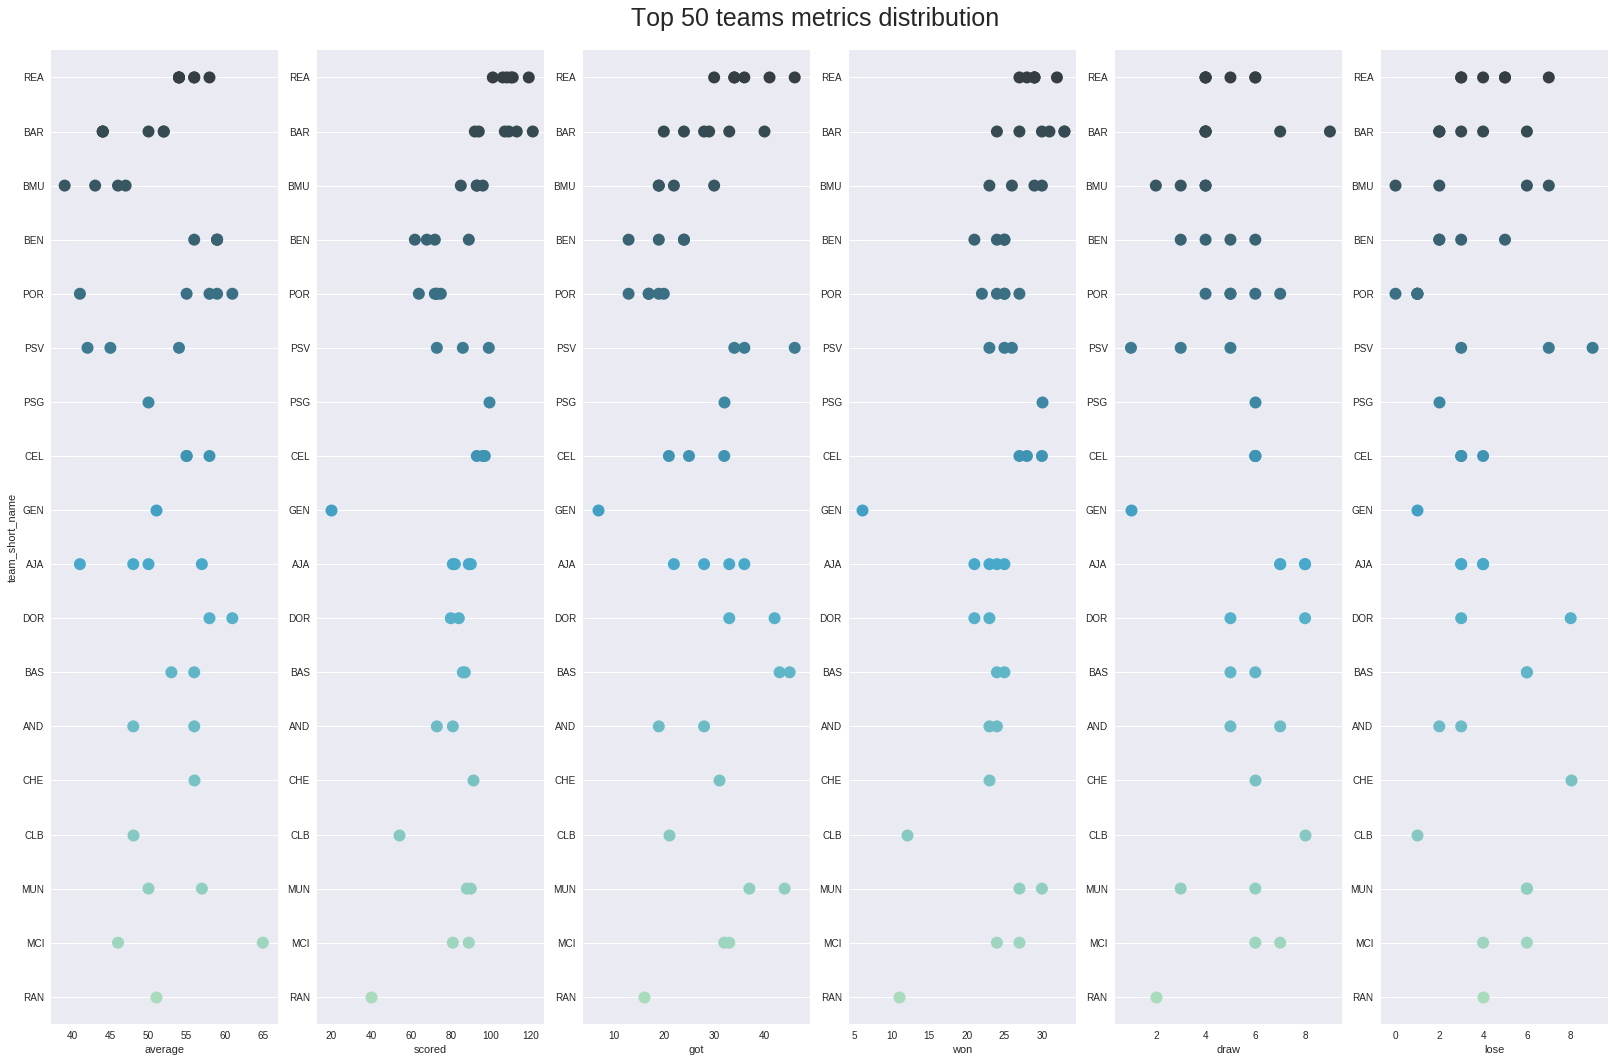

In [31]:
team_attr_df = pd.read_sql_query(SQLpatterns.select_team_attr_score, cn)
top_teams_ever(team_attr_df)

>Above is the list of top 50 teams based on "k" formula. Clearly top of the world is **Real Madrid** appears in the list 4 times. Now we can get closer to the point which of the teams made best progress. To answer this question lets select top 10 teams but now not on k column but delta which has been calculated in previous step and attached to data frame. To compare "improved" attributes against "something" we need to find same metrics but from preceding year. Lets select those. If previous year is not in the list lets take the one before that ("origin").
To be able to depict the data we need to transform it. For that reason we use pandas melt function (to get rid of many columns and represent data in two columns or less). We melt both list (impr and origin) Next we create figure and two axis to show how different data is between origin and improved.

In [32]:
def most_improved(team_df):
    top10impr = team_df.nlargest(10, 'delta')
    top10degr = team_df.nsmallest(10, 'delta')
    id_season = top10impr[['id', 'season']].values
    frames = []
    frm = lambda x: team_df.query('id == {} and season== {}'.format(r[0], r[1] - x))
    for r in id_season:
        i = 1
        size = frm(i).size
        while size == 0:
            i += 1
            size = frm(i).size
        else:
            frames.append(frm(i))
    origin = pd.concat(frames)
    melted_df_impr = pd.melt(top10impr, id_vars=['team_short_name'], value_vars=['scored', 'won', 'lose', 'k'])
    melted_df_orig = pd.melt(origin, id_vars=['team_short_name'], value_vars=['scored', 'won', 'lose', 'k'])

    sns.set_style("darkgrid")
    fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(15, 10))
    fig.suptitle('Most improved teams over 1 season', fontsize=20)
    b1 = sns.barplot(x='variable', y='value', hue='team_short_name', data=melted_df_orig, ax=ax1, palette='Set3')
    b2 = sns.barplot(x='variable', y='value', hue='team_short_name', data=melted_df_impr, ax=ax2, palette='Set3')
    b1.legend(title='short name')
    b2.legend(title='short name')
    ax1.set_xlabel("the teams's attr before best year")
    ax2.set_xlabel("Best year ever")
    plt.legend()

    top10impr['status'] = 'improved'
    origin['status'] = 'old'
    comboset = pd.concat([top10impr, origin])
    g = sns.factorplot(data=comboset, x='team_short_name', y='k', hue='status', kind='bar', size=12)
    g.despine(left=True)
    plt.title('Ration of old k and improved k over one season ')

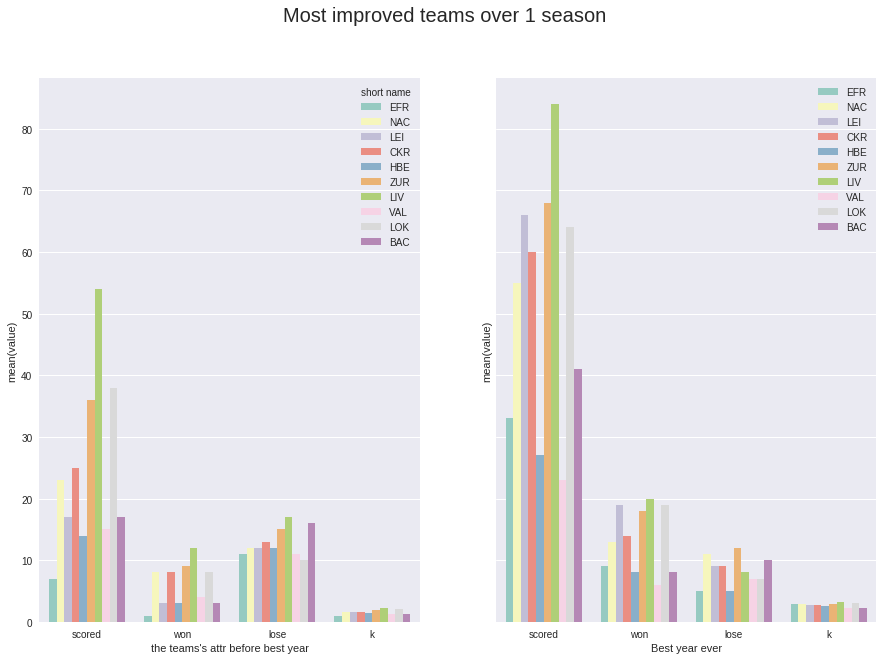

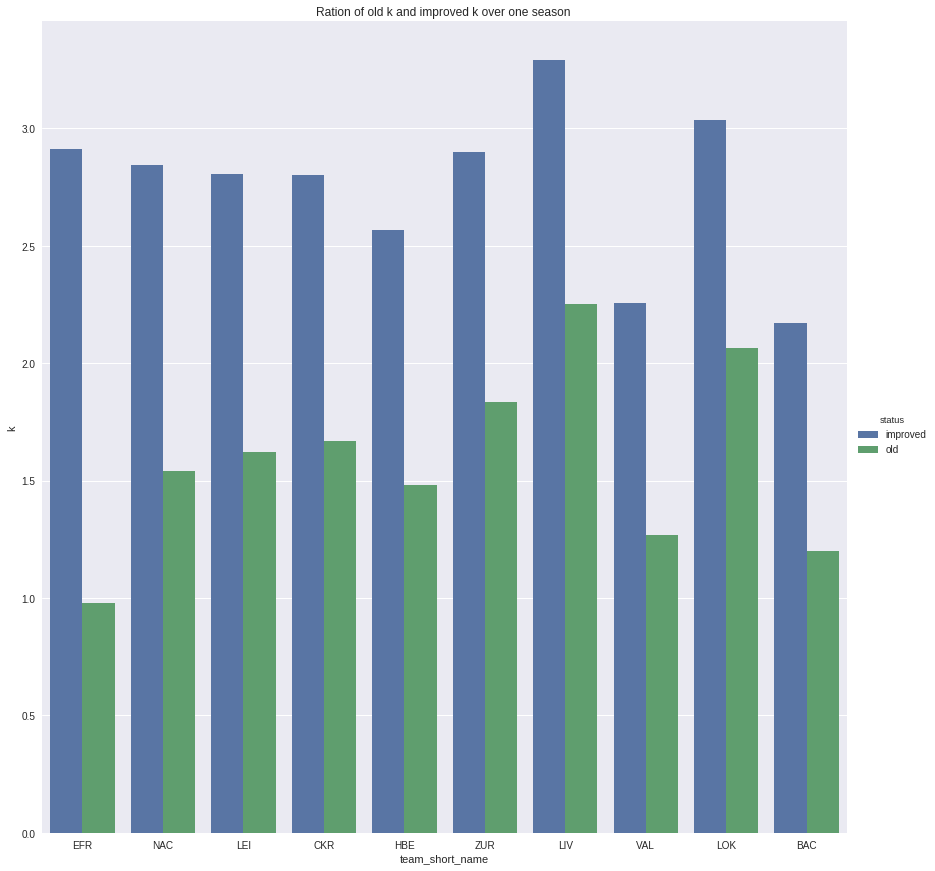

In [33]:
most_improved(team_attr_df)

<a id='limit_teams'></a>
### Limitations
- Most of team attributes are introduced as categorical values as those could not be included in aggregation procedure lots of categories dont participate in building team's performance.
- There are gaps in season data, not all years equally represented for given teams.
- The formula I based analysis on is created by myself so it doesnt have anything in common with real performance.

### Conclusion

Now we able to see top 10 improved teams over time and the one that did most of work is **Eintracht Frankfurt (EFR)**.

The other by descending order.    

CD Nacional (NAC) 2012    
Leicester City (LEI) 2012    
Cracovia (CKR) 2015    
Hertha BSC Berlin (HBE) 2015    
FC Zürich (ZUR) 2013    
Liverpool(LIV) 2013    
Real Valladolid(VAL) 2013    
Sporting Lokeren (LOK)2012    
Beerschot AC (BAC) 2011    

In [38]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])

0